In [1]:
# !/usr/local/lib/anaconda3/bin/python
# -*- coding: utf-8 -*-
import sys
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import *
import random
import pandas as pd
import csv

## ETKF

In [12]:
def L96(Xa,F):

    F_ = (np.roll(Xa, -1,axis=0) - np.roll(Xa, 2,axis=0)) * np.roll(Xa, 1,axis=0) -  Xa + F
    
    return F_

#4次のルンゲクッタ
def Rungekutta4(Xa,h,F):
    
    F_ = L96(Xa,F)
    K1 = h*F_

    X2=Xa+K1/2
    F_ = L96(X2,F)
    K2=h*F_
    
    X3=Xa+K2/2
    F_ = L96(X3,F)
    K3=h*F_
    
    X4=Xa+K3
    F_ = L96(X4,F)
    K4=h*F_
    
    Xb=Xa+K1/6+K2/3+K3/3+K4/6
    
    return Xb
def Forecast(Xa,m,b,L):
    h = 0.05 
    F = 8.0
    
    
    Xf = np.empty((N,m))
    Xf = Rungekutta4(Xa,h,F)
    #print(Xf)
    Xf_ = np.sum(Xf,axis=1)/m
    #print(Xf_.shape)
    #dX = [Xf[:,k]-Xf_ for k in range(m)]
    dXf = Xf - Xf_.reshape(-1,1)
    #dXf = np.array(dX).reshape(m,N).T
    dXf = dXf*b
    #print(dXf)
    Pf = dXf @ dXf.T/(m-1)
    # B=localization
    #Pf = Pf*L
    
    return Xf,Pf,dXf,Xf_

def Analysis(Xf,Pf,dXf,Xf_,y,m,a,mask,L):
    N = 40
    p = N-a
    H = np.identity(N)
    H=np.delete(H,mask,axis=0) #観測欠損 #観測行列
    R = np.eye(p)
    I = np.eye(N)
    
    dY = H @ dXf
    #カルマンゲインの導出
    A = H @ Pf @ H.T + R
    A_inv = np.linalg.inv(A)
    K = Pf @ H.T @ A_inv
    # K-localization
    K = K*L
    
    Xa_ = Xf_ + K @ (y - H @ Xf_)
    E = np.eye(m)
    TT = E - dY.T @ np.linalg.inv(dY @ dY.T+(m-1)*R) @ dY
    #print(TT)
    
    la,v = np.linalg.eigh(TT)
    #print(v)
    D = np.diag(np.sqrt(la))
    #print(D)
    U = np.array(v).reshape(m,m)
    
    T = U @ D
    #print(T @ T.T)
    dXa = dXf @ T
    Xa = np.zeros((N,m))
    Xa = dXa + Xa_.reshape(-1,1)
    
    Pa = dXa @ dXa.T/(m-1)
    
    return Xa,Pa,Xa_

0 20 2.0 0 1.1


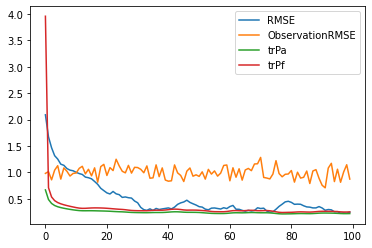

0.30641631030973454


In [13]:
t = 1460
N = 40
m = 20
h = 0.05 
F = 8.0

dataset = pd.read_csv("observation_data.csv")
Y = dataset.values.reshape(t,N)
dataset2 = pd.read_csv("data.csv")
Xt = dataset2.values.reshape(t,N)

MRMSE = []
for count in range(1):
    RMSE = []
    TrPa = []
    TrPf = []
    A = []
    B = []
    #for m in [40,20,15,10,8]:
    for i in range(1):
        a = i # observation miss
        sigma = 2.0
    #for j in range(1):
        b = 1.1
        #初期値
        Xa = np.empty((N,m))
        Xc = np.random.rand(N,m)
        for j in range(500):
            Xb = Rungekutta4(Xc,h,F)
            Xc = Xb
        Xa = Xb
        #plt.plot(Xa[:,9])
        #plt.plot(Xa[:,8])
        #plt.show()
        trPa = []
        trPf = []
        R = []
        Rf = []
        R_ = []
        RO = []
        for k in range(t):
            mask = np.random.choice(40,a,replace=False)
            y_ =np.delete(Y[k],mask)
            DB=np.zeros((N,N))
            DK=np.zeros((N,N-a))
            LB=np.zeros((N,N))
            LK=np.zeros((N,N-a))
            obs=np.arange(N)
            obs = np.delete(obs,mask)
            for s in range(N):
                for u in range(N):
                    DB[s,u] = min(abs(s-u),N-abs(s-u))
            for s in range(N):
                for u in range(N-a):
                    DK[s,u] = min(abs(s-obs[u]),N-abs(s-obs[u]))
            d0 = 2*np.sqrt(10/3)*sigma
            r0 = np.exp(-d0**2/(2*sigma**2))
            LB = np.exp(-DB**2/(2*sigma**2))
            LK = np.exp(-DK**2/(2*sigma**2))
            LB[LB<r0] = 0
            LK[LK<r0] = 0
            
            (Xf,Pf,dXf,Xf_) = Forecast(Xa,m,b,LB)
            (Xa,Pa,Xa_) = Analysis(Xf,Pf,dXf,Xf_,y_,m,a,mask,LK)
            #print(Xf)
    
            rmse=np.zeros(m)
            rmsef = np.zeros(m)
            rmse_=0
            X1 = Xt[k]
            Y1 = Y[k]
            rmse = np.sqrt(np.sum((Xa-X1.reshape(-1,1))*(Xa-X1.reshape(-1,1)),axis=0)/N)
            rmsef = np.sqrt(np.sum((Xf-X1.reshape(-1,1))*(Xf-X1.reshape(-1,1)),axis=0)/N)
            rmse_ = np.sqrt(np.sum((Xa_-X1)*(Xa_-X1))/N) 
            rmseo = np.sqrt(np.sum((Y1-X1)*(Y1-X1))/N)
            err = np.sqrt(np.sum(np.diag(Pa))/N)
            err2 = np.sqrt(np.sum(np.diag(Pf))/N)
            trPa.append(abs(err))
            trPf.append(abs(err2))
            R.append(rmse)
            Rf.append(rmsef)
            R_.append(rmse_)
            RO.append(rmseo)
            #if(k%100==0):
             #   print(k)
        rb = np.mean(np.array(R_[500:]))
        trPab = np.mean(np.array(trPa[500:]))
        trPfb = np.mean(np.array(trPf[500:]))
        RMSE.append(rb)
        TrPa.append(trPab)
        TrPf.append(trPfb)
        #A.append(sigma)
        A.append(a)
        B.append(b)
        print(count,m,sigma,a,b)
    MRMSE.append(RMSE)
#print(trPa)
#print(R)
plt.plot(R_[:100],label="RMSE")
plt.plot(RO[:100],label="ObservationRMSE")
plt.plot(trPa[:100],label="trPa")
plt.plot(trPf[:100],label="trPf")
plt.legend()
#plt.savefig("ETKF-KL.png")
plt.show()
print(np.mean(R_[500:]))

In [12]:
rmse = np.array(MRMSE)
RMSE = np.mean(rmse, 0)
df = pd.DataFrame(RMSE)
#df.to_csv("ETKF-BL-mem.csv")
df.to_csv("ETKF-BL-obsmiss.csv")

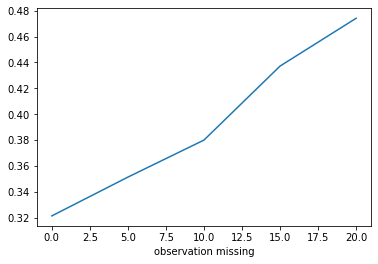

In [13]:
#A = [40,20,15,10,8]
plt.plot(A,RMSE,label="RMSE")
#plt.plot(A,TrPa,label="trPa")
#plt.plot(A,TrPf,label="trPf")
plt.xlabel("observation missing")
#plt.savefig("ETKF-noL-obsmiss.png")
plt.show()

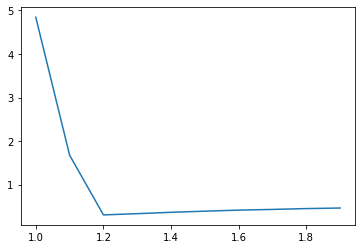

In [34]:
plt.plot(B,RMSE)
plt.show()

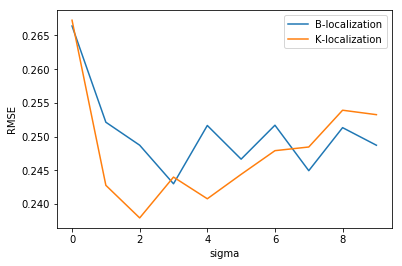

In [16]:
df1 = pd.read_csv("SRFB-localize.csv")
df2 = pd.read_csv("SRFK-localize.csv")
rmseB = df1.values
rmseK = df2.values
RB = rmseB[:,1]
RK = rmseK[:,1]
t = np.arange(1460)
plt.plot(RB,label="B-localization")
plt.plot(RK,label="K-localization")
plt.xlabel("sigma")
plt.ylabel("RMSE")
plt.legend()
plt.show()

(25, 2)
[[2.96345313 0.34794413 0.37534145 0.40860369 0.44439498]
 [2.32341121 0.33429019 0.37260342 0.39946916 0.43547068]
 [2.43593192 0.33502115 0.36237574 0.39437344 0.43092426]
 [2.95925046 0.33142383 0.36800126 0.39224439 0.42730161]
 [3.20994702 0.34047314 0.36556954 0.39673873 0.42643392]]


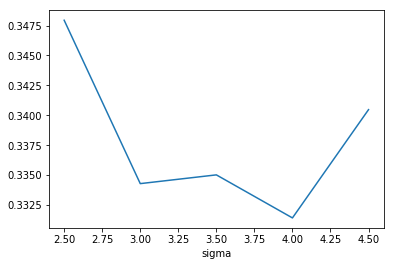

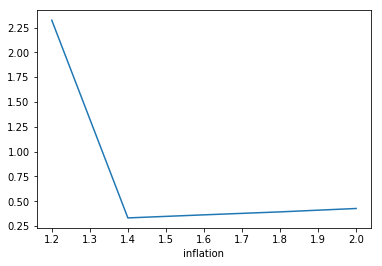

In [27]:
df=pd.read_csv("SRFm=10.csv")
rmse=df.values
print(rmse.shape)
R = rmse[:,1].reshape(5,5)
print(R)
y = [2.0+0.5*(i+1) for i in range(5)]
x = [1.0+0.2*(j+1) for j in range(5)]
Rsigma=[min(R[i,:]) for i in range(5)]
plt.plot(y,Rsigma)
plt.xlabel("sigma")
plt.show()
Rbeta = [min(R[:,i]) for i in range(5)]
plt.plot(x,Rbeta)
plt.xlabel("inflation")
plt.show()

0.35456417004836976


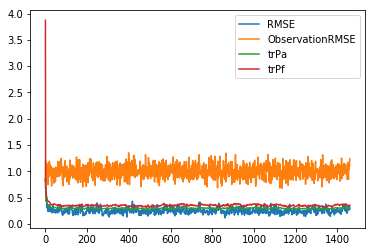

In [7]:
print(np.mean(R[500:]))
plt.plot(R_,label="RMSE")
plt.plot(RO,label="ObservationRMSE")
plt.plot(trPa,label="trPa")
plt.plot(trPf,label="trPf")
plt.legend()
#plt.savefig("SRF.jpg")
plt.show()

## EnSRF

In [14]:
def L96(Xa,F):
    
    F_ = (np.roll(Xa, -1,axis=0) - np.roll(Xa, 2,axis=0)) * np.roll(Xa, 1,axis=0) -  Xa + F
    
    return F_

#4次のルンゲクッタ
def Rungekutta4(Xa,h,F):
    
    
    F_ = L96(Xa,F)
    K1 = h*F_

    X2=Xa+K1/2
    F_ = L96(X2,F)
    K2=h*F_
    
    X3=Xa+K2/2
    F_ = L96(X3,F)
    K3=h*F_
    
    X4=Xa+K3
    F_ = L96(X4,F)
    K4=h*F_
    
    Xb=Xa+K1/6+K2/3+K3/3+K4/6
    
    return Xb
def Forecast(Xa,m,b):
    h = 0.05 
    F = 8.0
    
    
    Xf = np.zeros((N,m))
    Xf = Rungekutta4(Xa,h,F)
    #print(Xf)
    Xf_ = np.sum(Xf,axis=1)/m
    #print(Xf_.shape)
    dXf = Xf - Xf_.reshape(-1,1)
    dXf = dXf*b
    #Zf = dXf*b/np.sqrt(m-1)
    #print(dXf)
    Pf = dXf@dXf.T/(m-1)
    
    return Xf,Pf,dXf,Xf_

def Analysis(Xf,Pf,dXf,Xf_,y,m,a,loc):
    N = 40
    p = N-a
    H = np.identity(N)
    H = np.delete(H,loc,axis=0) #観測行列
    R = np.eye(p)
    I = np.eye(N)
    
    D=np.empty((N,N))
    L=np.empty((N,N))
    obs=np.arange(N)
    obs=np.delete(obs,loc)
    for s in range(N):
        for u in range(N):
            D[s,u] = min(abs(s-u),N-abs(s-u))
    d0 = 2*np.sqrt(10/3)*sigma
    r0 = np.exp(-d0**2/(2*sigma**2))
    L = np.exp(-D**2/(2*sigma**2))
    L[L<r0]=0
    
    P0 = Pf
    dX0 = dXf
    X0_ = Xf_
    for i in range(p):
        H_ = np.reshape(H[i,:],(1,-1))
        #V1 = (H_ @ Z0).T
        D1 = H_ @ P0 @ H_.T+R[i,i]
        #print(D1)
        K1 = P0 @ H_.T @ np.linalg.inv(D1)
        K1_ = K1/(1+np.sqrt(R[i,i]/D1))
        K1_ = K1_.reshape(-1,1)
        Xa_ = X0_+K1_ @ (y[i]-H_@X0_) 
        K_H = K1_ @ H_
        dXa = (I - K_H) @ dX0
        Pa = dXa@dXa.T/(m-1)
        Pa = Pa*L
        
        X0_ = Xa_
        dX0 = dXa
        P0 = Pa
        
    Xa = np.zeros((N,m))
    Xa = dXa + Xa_.reshape(-1,1)
    
    
    return Xa,Pa,Xa_



0 2.0 20 0 1.1
0 2.0 20 5 1.1
0 2.0 20 10 1.1
0 2.0 20 15 1.1
0 2.0 20 20 1.1
1 2.0 20 0 1.1
1 2.0 20 5 1.1
1 2.0 20 10 1.1
1 2.0 20 15 1.1
1 2.0 20 20 1.1
2 2.0 20 0 1.1
2 2.0 20 5 1.1
2 2.0 20 10 1.1
2 2.0 20 15 1.1
2 2.0 20 20 1.1
3 2.0 20 0 1.1
3 2.0 20 5 1.1
3 2.0 20 10 1.1
3 2.0 20 15 1.1
3 2.0 20 20 1.1
4 2.0 20 0 1.1
4 2.0 20 5 1.1
4 2.0 20 10 1.1
4 2.0 20 15 1.1
4 2.0 20 20 1.1
5 2.0 20 0 1.1
5 2.0 20 5 1.1
5 2.0 20 10 1.1
5 2.0 20 15 1.1
5 2.0 20 20 1.1
6 2.0 20 0 1.1
6 2.0 20 5 1.1
6 2.0 20 10 1.1
6 2.0 20 15 1.1
6 2.0 20 20 1.1
7 2.0 20 0 1.1
7 2.0 20 5 1.1
7 2.0 20 10 1.1
7 2.0 20 15 1.1
7 2.0 20 20 1.1
8 2.0 20 0 1.1
8 2.0 20 5 1.1
8 2.0 20 10 1.1
8 2.0 20 15 1.1
8 2.0 20 20 1.1
9 2.0 20 0 1.1
9 2.0 20 5 1.1
9 2.0 20 10 1.1
9 2.0 20 15 1.1
9 2.0 20 20 1.1


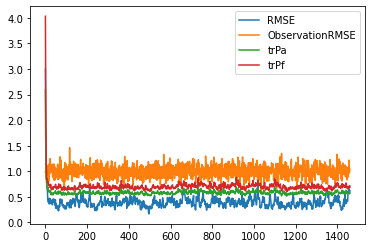

In [19]:

t = 1460
N = 40
m = 20
h = 0.05 
F = 8.0
#plt.show()

dataset = pd.read_csv("observation_data.csv")
Y = dataset.values.reshape(t,N)
dataset2 = pd.read_csv("data.csv")
Xt = dataset2.values.reshape(t,N)
MRMSE = []
for count in range(10):
    RMSE = []
    TrPa = []
    TrPf = []
    A = []
    B = []
    #for m in [40,20,15,10,8]:
    for i in range(0,21,5):
        a = i #observation missing
        sigma = 2.0
    #for j in range(1):
        b = 1.1
        #初期値
        Xa = np.zeros((N,m))
        Xc = np.random.rand(N,m)
        for j in range(500):
            Xb = Rungekutta4(Xc,h,F)
            Xc = Xb
        Xa = Xb
        #plt.plot(Xa[:,9])
        #plt.plot(Xa[:,8])

        trPa = []
        trPf = []
        R = []
        Rf = []
        R_ = []
        RO = []
        for k in range(t):
            loc = np.random.choice(N,a,replace=False)
            loc.sort() 
            y = np.delete(Y[k],loc)
            
            (Xf,Pf,Zf,Xf_) = Forecast(Xa,m,b)
            (Xa,Pa,Xa_) = Analysis(Xf,Pf,Zf,Xf_,y,m,a,loc)
            #print(Xf)
    
            rmse=np.zeros(m)
            rmsef = np.zeros(m)
            rmse_=0
            X1 = Xt[k]
            Y1 = Y[k]
            rmse = np.sum((Xa-X1.reshape(-1,1))**2,axis=0)
            rmsef = np.sum((Xf-X1.reshape(-1,1))**2,axis=0)
            rmse_ = np.sum((Xa_-X1)*(Xa_-X1)) 
            rmseo = np.sum((Y1-X1)*(Y1-X1))
            rmse = np.sqrt(rmse/N)
            rmsef = np.sqrt(rmsef/N)
            rmse_ = np.sqrt(rmse_/N)
            rmseo = np.sqrt(rmseo/N)
            err = 0
            err2 = 0
            err = np.sqrt(np.sum(np.diag(Pa))/N)
            err2 = np.sqrt(np.sum(np.diag(Pf))/N)
            trPa.append(abs(err))
            trPf.append(abs(err2))
            R.append(rmse)
            Rf.append(rmsef)
            R_.append(rmse_)
            RO.append(rmseo)
            #if(k%100==0):
             #   print(k)
        rb = np.sum(np.array(R_[500:]))/(t-500)
        trPab = np.sum(np.array(trPa[500:]))/(t-500)
        trPfb = np.sum(np.array(trPf[500:]))/(t-500)
        RMSE.append(rb)
        TrPa.append(trPab)
        TrPf.append(trPfb)
        A.append(a)
        B.append(b)
        print(count,sigma,m,a,b)
    MRMSE.append(RMSE)
#print(trPa)
#print(R)
#plt.plot(A,RMSE,label="RMSE")
#plt.plot(A,TrPa,label="trPa")
#plt.plot(A,TrPf,label="trPf")
#plt.xlabel("observation missing")
plt.plot(R_,label="RMSE")
plt.plot(RO,label="ObservationRMSE")
plt.plot(trPa,label="trPa")
plt.plot(trPf,label="trPf")
plt.legend()
#plt.savefig("SRF-L.png")
plt.show()
#print(RMSE)
rmse = np.array(MRMSE)
RMSE = np.mean(rmse, 0)
df = pd.DataFrame(RMSE)
df.to_csv("SRF-BL-obsmiss.csv")

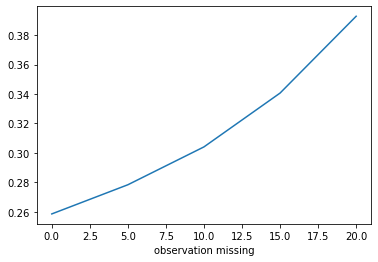

In [20]:
#A = [40,20,15,10,8]
plt.plot(A,RMSE,label="RMSE")
#plt.plot(A,TrPa,label="trPa")
#plt.plot(A,TrPf,label="trPf")
plt.xlabel("observation missing")
#plt.savefig("ETKF-noL-obsmiss.png")
plt.show()

## PO法

In [21]:
def L96(Xa,F):
    
    F_ = (np.roll(Xa, -1, axis=0) - np.roll(Xa, 2, axis=0)) * np.roll(Xa, 1, axis=0) -  Xa + F
    
    return F_

#4次のルンゲクッタ
def Rungekutta4(Xa,h,F):
    
    F_ = L96(Xa,F)
    K1 = h*F_

    X2=Xa+K1/2
    F_ = L96(X2,F)
    K2=h*F_
    
    X3=Xa+K2/2
    F_ = L96(X3,F)
    K3=h*F_
    
    X4=Xa+K3
    F_ = L96(X4,F)
    K4=h*F_
    
    Xb=Xa+K1/6+K2/3+K3/3+K4/6
    
    return Xb

def Forecast(Xa,y,m,a,alpha,L):
    h = 0.05 
    F = 8.0
    N = 40
    b = 0.01
    p = N-a
    H = np.identity(N)
    H = np.delete(H,loc,axis=0) #観測行列
    R = np.eye(p)
    I = np.eye(N)
    
    Xf = np.zeros((N,m))
    Xf = Rungekutta4(Xa,h,F)
    #print(Xf)
    Xf_ = np.sum(Xf,axis=1)/m
    #print(Xf_.shape)
    dXf = Xf - Xf_.reshape(-1,1)
    #print(dXf)
    Pf = dXf @ dXf.T/(m-1)
    # B-localization
    #Pf = Pf*L
    
    # inflation
    Pf = Pf * alpha
    
    return Xf,Pf,dXf,Xf_

def Analysis(Xf,Pf,dXf,Xf_,y,EO,m,a,loc,L):
    N = 40
    p = N-a
    H = np.identity(N)
    H = np.delete(H,loc,axis=0) #観測行列
    R = np.eye(p)
    I = np.eye(N)
    
    Y = np.zeros((p,m))
    Y = y.reshape(-1,1) + EO
    #dY = H @ dXf
    #カルマンゲインの導出
    K = Pf @ H.T @ np.linalg.inv(H @ Pf @ H.T + R)
    # K-localization
    K = K*L
    
    Xa = Xf + K @ (Y - H @ Xf)
    Xa_ = Xf_ + K @ (y - H @ Xf_)
    Pa = (I - K @ H)@ Pf
    
    return Xa,Xa_,Pa

8 2.0 0 1.1
8 2.0 5 1.1
8 2.0 10 1.1
8 2.0 15 1.1
8 2.0 20 1.1
8 2.0 0 1.1
8 2.0 5 1.1
8 2.0 10 1.1
8 2.0 15 1.1
8 2.0 20 1.1
8 2.0 0 1.1
8 2.0 5 1.1
8 2.0 10 1.1
8 2.0 15 1.1
8 2.0 20 1.1
8 2.0 0 1.1
8 2.0 5 1.1
8 2.0 10 1.1
8 2.0 15 1.1
8 2.0 20 1.1
8 2.0 0 1.1
8 2.0 5 1.1
8 2.0 10 1.1
8 2.0 15 1.1
8 2.0 20 1.1
8 2.0 0 1.1
8 2.0 5 1.1
8 2.0 10 1.1
8 2.0 15 1.1
8 2.0 20 1.1
8 2.0 0 1.1
8 2.0 5 1.1
8 2.0 10 1.1
8 2.0 15 1.1
8 2.0 20 1.1
8 2.0 0 1.1
8 2.0 5 1.1
8 2.0 10 1.1
8 2.0 15 1.1
8 2.0 20 1.1
8 2.0 0 1.1
8 2.0 5 1.1
8 2.0 10 1.1
8 2.0 15 1.1
8 2.0 20 1.1
8 2.0 0 1.1
8 2.0 5 1.1
8 2.0 10 1.1
8 2.0 15 1.1
8 2.0 20 1.1


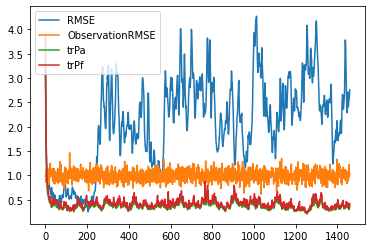

2.4360608680621465


In [24]:
t = 1460
N = 40
#m = 20
h = 0.05 
F = 8.0

dataset = pd.read_csv("observation_data.csv")
Y = dataset.values.reshape(t,N)
dataset2 = pd.read_csv("data.csv")
Xt = dataset2.values.reshape(t,N)
MRMSE = []
for count in range(10):
    RMSE = []
    TrPa = []
    TrPf = []
    B = []
    A = []
    #for m in [40,20,15,10,8]:
    for i in range(0,21,5):
        sigma = 2.0
        a = i     # observation miss
    #for j in range(1):
        b = 1.1
        #初期値
        Xa = np.zeros((N,m))
        Xc = np.random.rand(N,m)
        for j in range(500):
            Xb = Rungekutta4(Xc,h,F)
            Xc = Xb
        Xa = Xb
        #plt.plot(Xa[:,39])
        #plt.plot(Xa[:,38])
        #plt.show()

        # perturbed observation random number
        mu = np.zeros(N-a)
        sigma2 = np.eye(N-a)
        EO = multivariate_normal(mu,sigma2,m).T
        #print(EO.shape)
        
        trPa = []
        trPf = []
        R = []
        Rf = []
        R_ = []
        RO = []
        for k in range(t):
            # localization matrix
            loc = np.random.choice(N,a,replace=False)
            y = np.delete(Y[k],loc)
            DB = np.zeros((N,N))
            DK = np.zeros((N,N-a))
            LB = np.zeros((N,N))
            LK = np.zeros((N,N-a))
            obs = np.arange(N)
            obs = np.delete(obs,loc)
            for s in range(N):
                for u in range(N):
                    DB[s,u] = min(abs(s-u),N-abs(s-u))
            for s in range(N):
                for u in range(N-a):
                    DK[s,u] = min(abs(s-obs[u]),N-abs(s-obs[u]))
            d0 = 2*np.sqrt(10/3)*sigma
            r0 = np.exp(-d0**2/(2*sigma**2))
            LB = np.exp(-DB**2/(2*sigma**2))
            LK = np.exp(-DK**2/(2*sigma**2))
            LB[LB<r0] = 0
            LK[LK<r0] = 0
        
            #(Xf,Pf,dXf,Xf_,alpha) = Forecast(Xa,y,m,a,A[-1],L)
            (Xf,Pf,dXf,Xf_) = Forecast(Xa,y,m,a,b,LB)
            (Xa,Xa_,Pa) = Analysis(Xf,Pf,dXf,Xf_,y,EO,m,a,loc,LK)
            
            rmse=np.zeros(m)
            rmsef = np.zeros(m)
            rmse_=0
            X1 = Xt[k,:]
            Y1 = Y[k,:]
            rmse = np.sum((Xa-X1.reshape(-1,1))**2)
            rmsef = np.sum((Xf-X1.reshape(-1,1))**2)
            rmse_ = np.sum((Xa_-X1)*(Xa_-X1)) 
            rmseo = np.sum((Y1-X1)*(Y1-X1))
            rmse = np.sqrt(rmse/N)
            rmsef = np.sqrt(rmsef/N)
            rmse_ = np.sqrt(rmse_/N)
            rmseo = np.sqrt(rmseo/N)
            err = 0
            err2 = 0
            err = np.sqrt(np.sum(np.diag(Pa))/N)
            err2 = np.sqrt(np.sum(np.diag(Pf))/N)
            trPa.append(abs(err))
            trPf.append(abs(err2))
            R.append(rmse)
            Rf.append(rmsef)
            R_.append(rmse_)
            RO.append(rmseo)
            #if(k%100==0):
                #print(k)
        rb = np.sum(np.array(R_[500:]))/(t-500)
        trPab = np.sum(np.array(trPa[500:]))/(t-500)
        trPfb = np.sum(np.array(trPf[500:]))/(t-500)
        RMSE.append(rb)
        TrPa.append(trPab)
        TrPf.append(trPfb)
        A.append(a)
        B.append(b)
        print(m,sigma,a,b)
    MRMSE.append(RMSE)
    
plt.plot(R_,label="RMSE")
plt.plot(RO,label="ObservationRMSE")
plt.plot(trPa,label="trPa")
plt.plot(trPf,label="trPf")
plt.legend()
#plt.savefig("PO-noL.png")
plt.show()
print(np.mean(R_[500:]))
rmse = np.array(MRMSE)
RMSE = np.mean(rmse, 0)
df = pd.DataFrame(RMSE)
df.to_csv("PO-KL-obsmiss.csv")

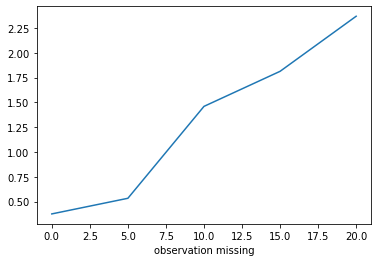

In [25]:
#A = [40,20,15,10,8]
plt.plot(A,RMSE,label="RMSE")
#plt.plot(A,TrPa,label="trPa")
#plt.plot(A,TrPf,label="trPf")
plt.xlabel("observation missing")
#plt.savefig("ETKF-noL-obsmiss.png")
plt.show()

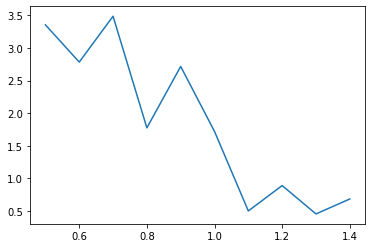

In [30]:
plt.plot(A_,RMSE)
plt.show()

## LETKF

In [8]:
def L96(Xa,F):
    
    F_ = (np.roll(Xa, -1,axis=0) - np.roll(Xa, 2,axis=0)) * np.roll(Xa, 1,axis=0) -  Xa + F
    
    return F_

#4次のルンゲクッタ
def Rungekutta4(Xa,h,F):
    
    F_ = L96(Xa,F)
    K1 = h*F_

    X2=Xa+K1/2
    F_ = L96(X2,F)
    K2=h*F_
    
    X3=Xa+K2/2
    F_ = L96(X3,F)
    K3=h*F_
    
    X4=Xa+K3
    F_ = L96(X4,F)
    K4=h*F_
    
    Xb=Xa+K1/6+K2/3+K3/3+K4/6
    
    return Xb

def Forecast(Xa,m):
    h = 0.05 
    F = 8.0
    
    
    Xf = np.zeros((N,m))
    Xf = Rungekutta4(Xa,h,F)
    #print(Xf)
    Xf_ = np.sum(Xf,axis=1)/m
    #print(Xf_.shape)
    dXf = Xf - Xf_.reshape(-1,1)
    #print(dXf)
    Pf = dXf @ dXf.T/(m-1)
    #Pf = Pf*L
    
    return Xf,Pf,dXf,Xf_

def Analysis(dXf,Xf_,y,m,a,loc,rho,sigma):
    N = 40
    p = N-a
    H = np.identity(N)
    H = np.delete(H,loc,axis=0) #観測行列
    R = np.eye(p)
    I = np.eye(m)

    obs=np.arange(N)
    obs=np.delete(obs,loc)
    D = np.zeros((N,p))
    for s in range(N):
        for u in range(p):
            D[s,u] = min(abs(s-obs[u]),N-abs(s-obs[u]))
    #print(obs)
    Xa = np.zeros((N,m))
    Xa_ = np.zeros(N)
    dXa = np.zeros((N,m))
    #使う値は前後10点に限定
    for i in range(N):
        d = D[i]
        far = np.arange(p)
        far = far[d>2*np.sqrt(10/3)*sigma]
        yi = y
        Hi = H
        Ri = R
        yi = np.delete(yi,far)
        Hi = np.delete(Hi,far,axis=0)
        Ri = np.delete(Ri,far,axis=0)
        Ri = np.delete(Ri,far,axis=1)
        #print(yi.shape,Hi.shape,Ri.shape)
        diagR = np.diag(Ri)
        di = yi - Hi @ Xf_
        dYi = Hi @ dXf
        # R-localization
        #L = np.exp(-d**2/(2*sigma**2))
        #L = np.delete(L,far)
        #Ri = np.diag(diagR/L)
        R_inv = np.linalg.inv(Ri)
    
        A = (m-1)*I/rho + dYi.T @ R_inv @ dYi
        la,v = np.linalg.eigh(A) #eigenvalue decomposition
        D_inv = np.linalg.inv(np.diag(la))
        U = np.array(v).reshape(m,m)
        Pa_ = U @ D_inv @ U.T #UD^(-1)UT
        #print(Pa_)
    
        Xa_[i] = Xf_[i] + dXf[i,:] @ Pa_ @ dYi.T @ R_inv @ di 
        Pa_root = U @ np.sqrt(D_inv) @ U.T
        Pa_root = Pa_root * np.sqrt(m-1)
        dXa[i,:] = dXf[i,:] @ Pa_root
        Xa[i,:] = np.full(m,Xa_[i]) + dXa[i,:]
            
    #print("Xa_",Xa_)
    #print("dXa",dXa)
    #print("Xa",Xa)
    Pa = dXa @ dXa.T/(m-1)
    
    return Xa,Pa,Xa_

20 0 7.5 1.2


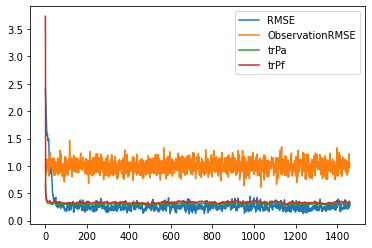

0.25159641248280895


In [9]:

t = 1460
N = 40
m = 20
h = 0.05 
F = 8.0

dataset = pd.read_csv("observation_data.csv")
Y = dataset.values.reshape(t,N)
dataset2 = pd.read_csv("data.csv")
Xt = dataset2.values.reshape(t,N)
MRMSE = []
for count in range(1):
    RMSE = []
    TrPa = []
    TrPf = []
    A = []
    B = []
    #for m in [40,20,15,10,8]:
    for i in range(1):
        a = i # observation miss
        sigma = 7.5
    #for j in range(1):
        rho = 1.2
        #初期値
        Xa = np.zeros((N,m))
        Xc = np.random.rand(N,m)
        for j in range(500):
            Xb = Rungekutta4(Xc,h,F)
            Xc = Xb
        Xa = Xb
        #plt.plot(Xa[:,9])
        #plt.plot(Xa[:,8])

        trPa = []
        trPf = []
        R = []
        Rf = []
        R_ = []
        RO = []
        for k in range(t):
            loc = np.random.choice(N,a,replace=False)
            loc.sort() 
            y = np.delete(Y[k],loc)
            
            (Xf,Pf,dXf,Xf_) = Forecast(Xa,m)
            (Xa,Pa,Xa_) = Analysis(dXf,Xf_,y,m,a,loc,rho,sigma)
            #print(Xf)
    
            rmse=np.zeros(m)
            rmsef = np.zeros(m)
            rmse_=0
            X1 = Xt[k,:]
            Y1 = Y[k,:]
            rmse = np.sum((Xa-X1.reshape(-1,1))**2)
            rmsef = np.sum((Xf-X1.reshape(-1,1))**2)
            rmse_ = np.sum((Xa_-X1)*(Xa_-X1)) 
            rmseo = np.sum((Y1-X1)*(Y1-X1))
            rmse = np.sqrt(rmse/N)
            rmsef = np.sqrt(rmsef/N)
            rmse_ = np.sqrt(rmse_/N)
            rmseo = np.sqrt(rmseo/N)
            err = 0
            err2 = 0
            err = np.sqrt(np.sum(np.diag(Pa))/N)
            err2 = np.sqrt(np.sum(np.diag(Pf))/N)
            trPa.append(abs(err))
            trPf.append(abs(err2))
            R.append(rmse)
            Rf.append(rmsef)
            R_.append(rmse_)
            RO.append(rmseo)
            #if(k%100==0):
             #   print(k)
        rb = np.sum(np.array(R_[500:]))/(t-500)
        trPab = np.sum(np.array(trPa[500:]))/(t-500)
        trPfb = np.sum(np.array(trPf[500:]))/(t-500)
        RMSE.append(rb)
        TrPa.append(trPab)
        TrPf.append(trPfb)
        A.append(a)
        B.append(rho)
        print(m,a,sigma,rho)
    MRMSE.append(RMSE)
#print(trPa)
#print(R)
#plt.plot(A,RMSE,label="RMSE")
#plt.plot(A,TrPa,label="trPa")
#plt.plot(A,TrPf,label="trPf")
#plt.xlabel("observation missing")
plt.plot(R_,label="RMSE")
plt.plot(RO,label="ObservationRMSE")
plt.plot(trPa,label="trPa")
plt.plot(trPf,label="trPf")
plt.legend()
#plt.savefig("LETKF-noRL.png")
plt.show()
print(np.mean(R_[500:]))
rmse = np.array(MRMSE)
RMSE = np.mean(rmse, 0)
df = pd.DataFrame(RMSE)
df.to_csv("LETKF-obsmiss.csv")

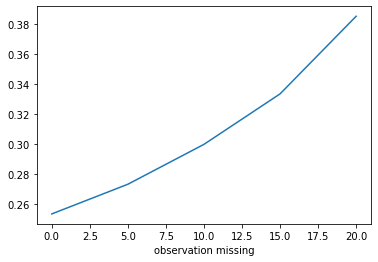

In [30]:
#A = [40,20,15,10,8]
plt.plot(A,RMSE,label="RMSE")
#plt.plot(A,TrPa,label="trPa")
#plt.plot(A,TrPf,label="trPf")
plt.xlabel("observation missing")
#plt.savefig("ETKF-noL-obsmiss.png")
plt.show()

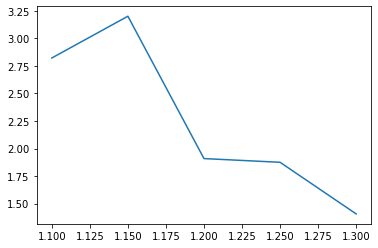

In [34]:
plt.plot(B,RMSE)
plt.show()

(25, 2)
[[4.24060005 4.0692214  3.73785776 3.50856837 1.95377544]
 [4.28798297 3.64981553 3.12043776 3.29600385 2.25741734]
 [4.28897523 3.97133728 3.67257539 3.20172574 0.2631509 ]
 [4.54344807 3.89413521 3.34284482 2.91762577 0.49667802]
 [4.45839585 4.03699237 3.38665278 3.10016173 2.20567116]]


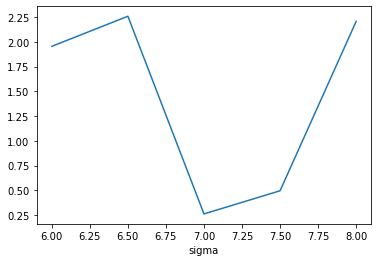

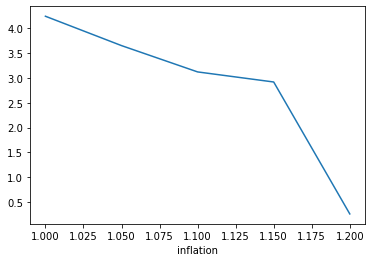

In [32]:
df=pd.read_csv("LETKF.csv")
rmse=df.values
print(rmse.shape)
R = rmse[:,1].reshape(5,5)
print(R)
x=[1.0+0.05*(j) for j in range(5)]
y = [6.0+0.5*(i) for i in range(5)]
Rsigma=[min(R[i,:]) for i in range(5)]
plt.plot(y,Rsigma)
plt.xlabel("sigma")
plt.show()
Rbeta = [min(R[:,i]) for i in range(5)]
plt.plot(x,Rbeta)
plt.xlabel("inflation")
plt.show()

In [6]:
print(rand(10).shape)
H = np.array([1,0,0,0,0,0,0,1,0,0,0,0,0,0,1]).reshape(3,5)
Zf=np.array([2,1,0,0,0,3,2,1,0,0]).reshape(5,2)
print(Zf)
H_=np.reshape(H[1,:],(1,-1))
print(H_)
V = (H_ @ Zf ).T
print(V)
D = V.T @ V +1
print(D)
K = Zf @ V/(D+np.sqrt(D))
print(K)
K_ = np.empty((5,0))
for i in range(3):
    K_ = np.append(K_,K,axis=1)
print(K_)

(10,)
[[2 1]
 [0 0]
 [0 3]
 [2 1]
 [0 0]]
[[0 0 1 0 0]]
[[0]
 [3]]
[[10]]
[[0.22792408]
 [0.        ]
 [0.68377223]
 [0.22792408]
 [0.        ]]
[[0.22792408 0.22792408 0.22792408]
 [0.         0.         0.        ]
 [0.68377223 0.68377223 0.68377223]
 [0.22792408 0.22792408 0.22792408]
 [0.         0.         0.        ]]


(11,)


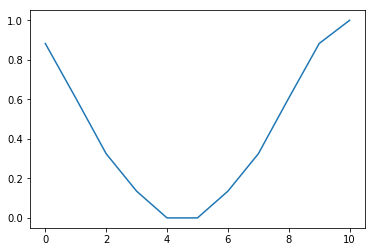

In [15]:
print(L.shape)
plt.plot(L)
plt.show()

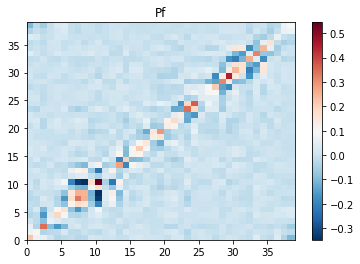

In [46]:
x = np.arange(40)
y = np.arange(40)
plt.pcolor(x,y,Pf,cmap='RdBu_r')
plt.colorbar()
plt.title("Pf")
plt.show()

[]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
[[0. 1. 2. ... 3. 2. 1.]
 [1. 0. 1. ... 4. 3. 2.]
 [2. 1. 0. ... 5. 4. 3.]
 ...
 [3. 4. 5. ... 0. 1. 2.]
 [2. 3. 4. ... 1. 0. 1.]
 [1. 2. 3. ... 2. 1. 0.]]
[[1.         0.45783336 0.04393693 ... 0.         0.04393693 0.45783336]
 [0.45783336 1.         0.45783336 ... 0.         0.         0.04393693]
 [0.04393693 0.45783336 1.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 1.         0.45783336 0.04393693]
 [0.04393693 0.         0.         ... 0.45783336 1.         0.45783336]
 [0.45783336 0.04393693 0.         ... 0.04393693 0.45783336 1.        ]]


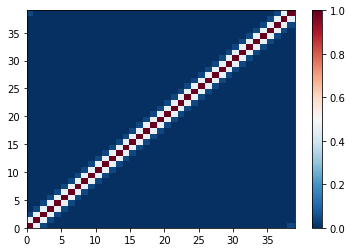

In [36]:
N=40
a=0
p=N-a
sigma=0.8
D = np.zeros((N,p))
L = np.zeros((N,p))
loc = np.random.choice(N,a,replace=False)
loc.sort()
print(loc)
r=0
obs=np.arange(N)
obs=np.delete(obs,loc)
print(obs)
for s in range(N):
    for u in range(N-a):
        D[s,u] = min(abs(s-obs[u]),N-abs(s-obs[u]))
print(D)        
A=D>5
#print(A)
#print(D[A])
d0=2*np.sqrt(10/3)*sigma
r0=np.exp(-d0**2/(2*sigma**2))
L=np.exp(-D**2/(2*sigma**2))
L[L<r0]=0
x=np.arange(p)
y=np.arange(N)
#P = L*Pf
print(L)
plt.pcolor(x,y,L,cmap='RdBu_r')
plt.colorbar()
#plt.title("L*Pf")
#plt.show()

#L2 = np.exp(-D/2)
#print(L2*L2)
#dX = L2*dXf
#P2 = dX @ dX.T/(m-1)
#print(P2)